In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [72]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots()
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#000000', '#004488', '#bb5566', '#ddaa33']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            plt.step(xdatas[i], ydatas[i], where='mid', linestyle=styles[i],
                     label=pl_labels[i], colors=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'")
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#000000', '#004488', '#bb5566', '#ddaa33']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes.reshape(numrows, numcols)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]))[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr.append(sim_detmask)
        det_mask_obs_arr.append(obs_detmask)
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Simulated ' + det_names[i] + ' spectra',
                                    'Observed ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], colors_std[i], median_colors[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    return np.mean(bin_colors), np.std(bin_colors), np.median(bin_colors)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[prop_list[i], 0.5*(prop_binslist[i][1:] +
                                           prop_binslist[i][:-1]),
                        0.5*(prop_binslist[i][1:] + prop_binslist[i][:-1])],
                       [obs_props[i], 0.5*(prop_binslist[i][1:] +
                                           prop_binslist[i][:-1]),
                        0.5*(prop_binslist[i][1:] + prop_binslist[i][:-1])]],
                [[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors + 2*colors_std]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']],
                xlabel_arr=[prop_listnames[i], prop_listnames[i]],
                ylabel_arr=['Simulated source colors',
                            'Observed source colors'],
                pl_labels_arr=[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                               ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths,
                 range_fe=None, range_cont1=None, range_cont2=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='msp_highNH_')
            (source_nums, [obs1_mask, obs1_specs, obs1_bgs],
             [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
                obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='msp_highNH_')
            src_names, obs_specs, obs_bgs = load_chandraspec_obs(
                obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, [2, 10], True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.
    
    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    ebins_lowhigh = spec_summary['elowhigh']
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names,
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)



def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask, det_name,
                      det_obs_ebins=None, det_obs_srcspecs=None,
                      det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


812:1: W293 blank line contains whitespace
874:5: F841 local variable 'ebins_lowhigh' is assigned to but never used
895:1: E303 too many blank lines (3)
895:80: E501 line too long (80 > 79 characters)
896:23: E128 continuation line under-indented for visual indent
897:23: E128 continuation line under-indented for visual indent


In [69]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep_GB_sources/chandra_deep_combined_spec/2CXOJ174525.2-290632_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_msp_sim_highNH/'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/sim_msps_highNH_PN_MOS/'
chandra_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/Galactic_highNH_combinedXMM/'

1:80: E501 line too long (170 > 79 characters)
2:80: E501 line too long (115 > 79 characters)
3:80: E501 line too long (120 > 79 characters)
4:80: E501 line too long (100 > 79 characters)
5:80: E501 line too long (96 > 79 characters)
6:80: E501 line too long (91 > 79 characters)


In [70]:
set_plotparams('notebook')

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:472: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:473: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:559: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:560: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:563: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:563: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:565: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

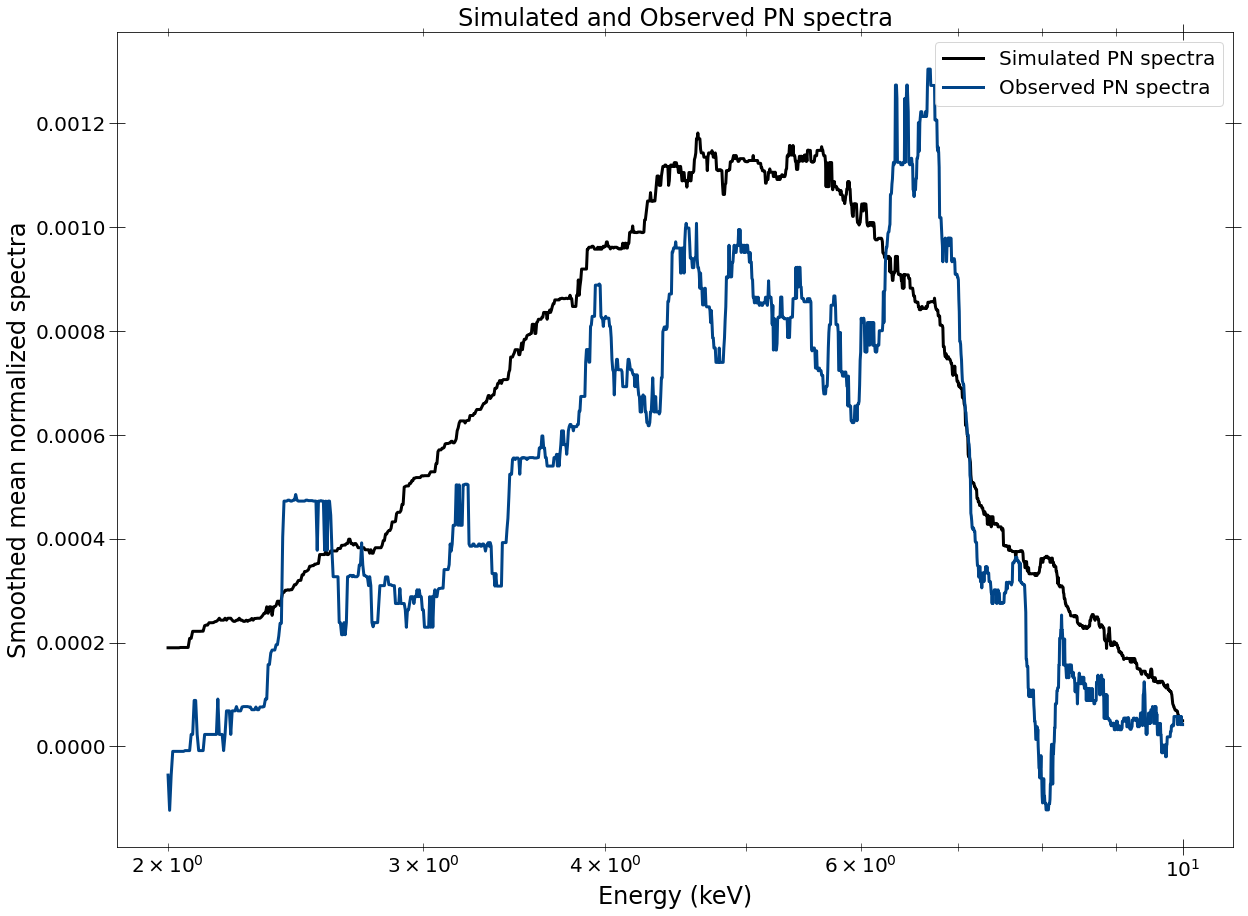

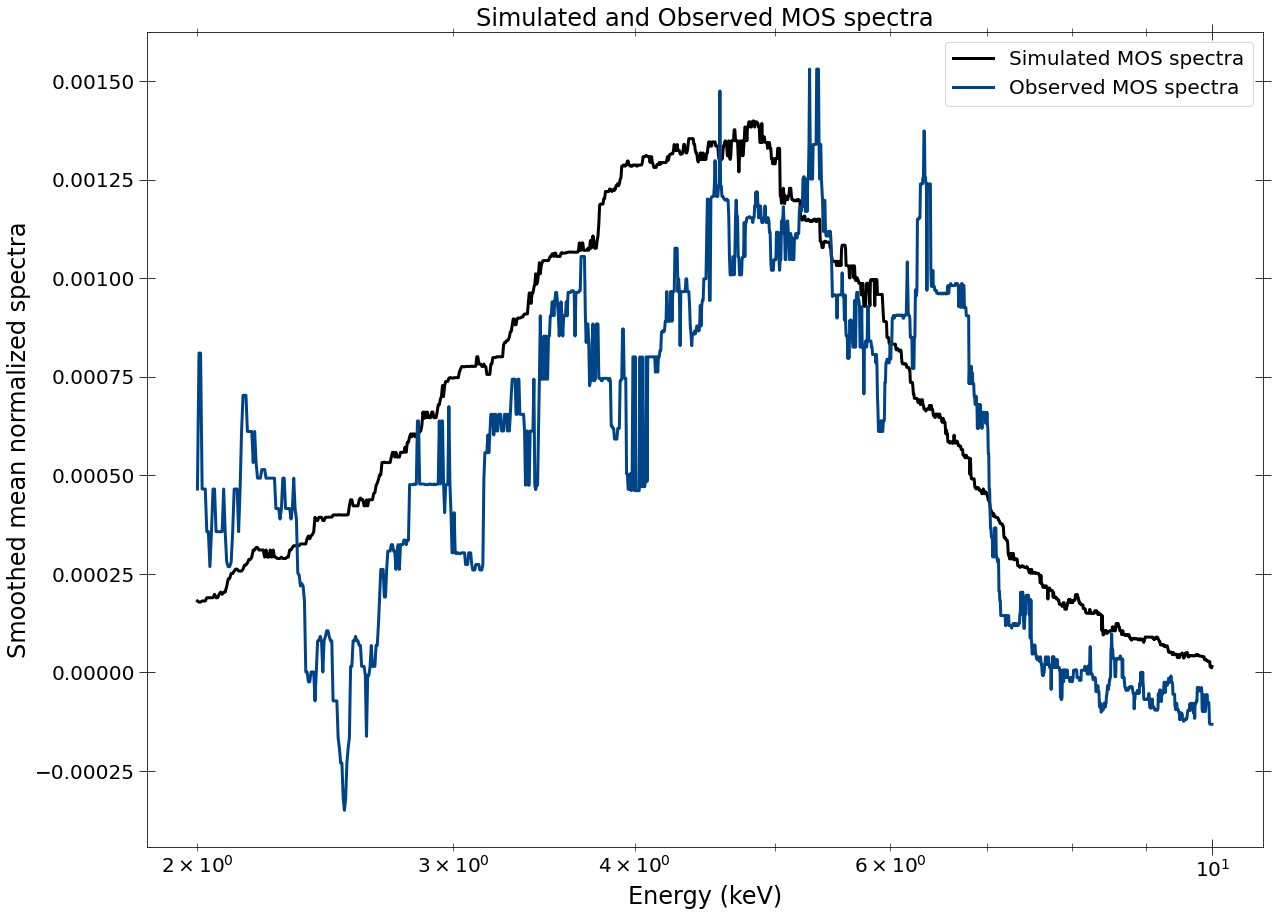

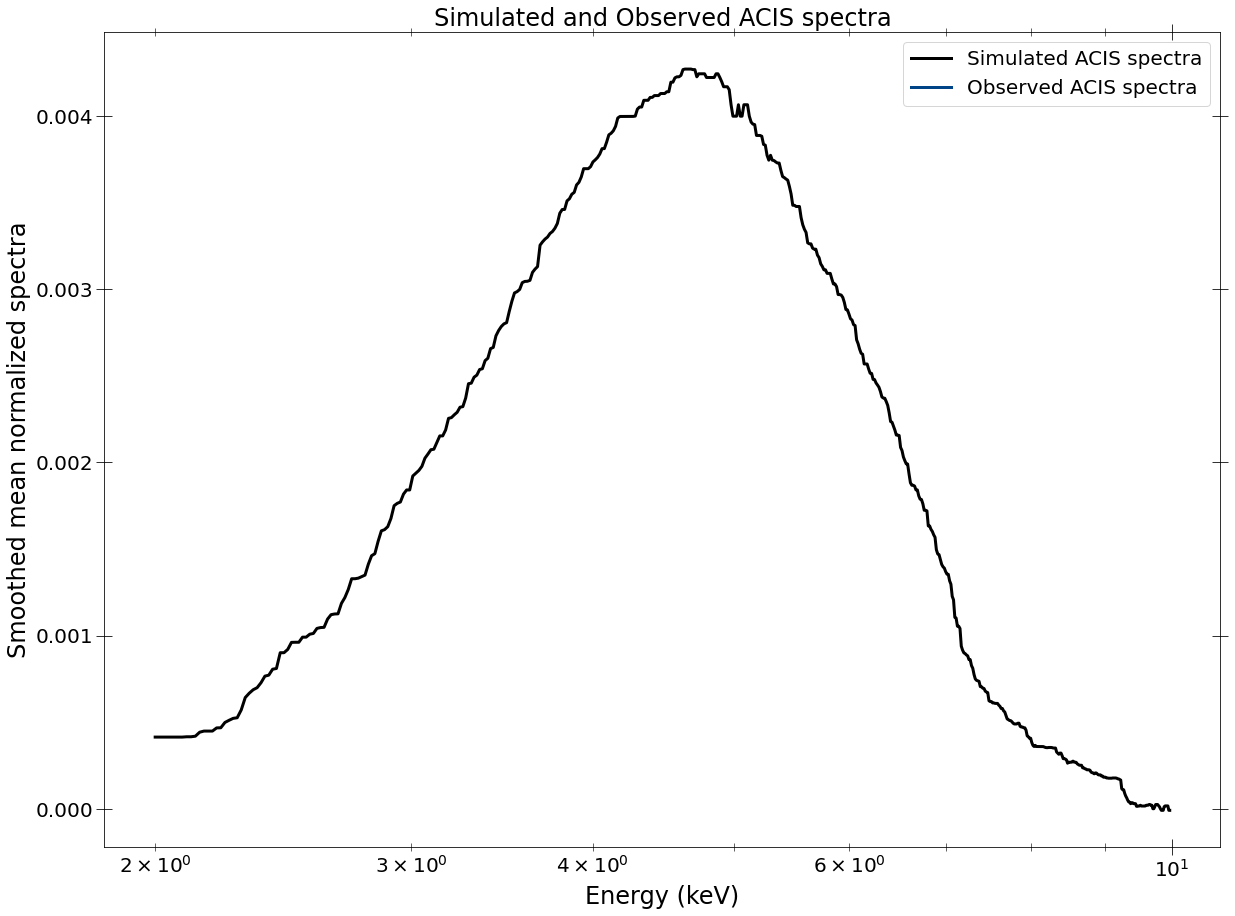

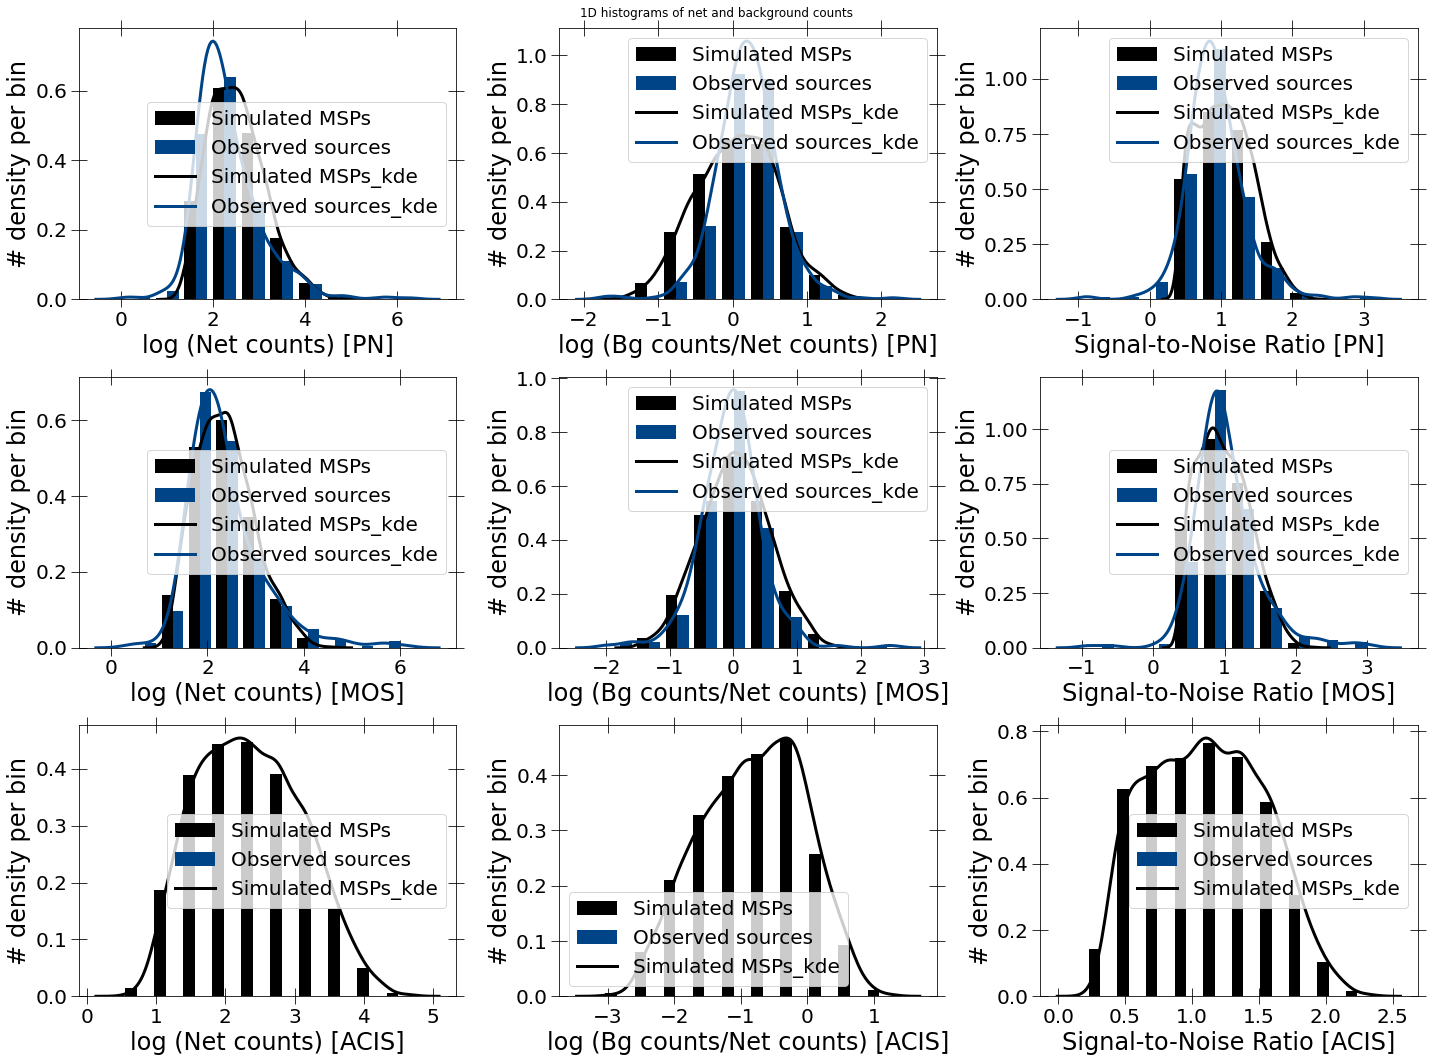

In [73]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path])

In [65]:
load_chandraspec_obs(chandra_obs_path)

['/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174430.1-285333/2CXOJ174430.1-285333_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174435.1-284651/2CXOJ174435.1-284651_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174451.6-285416/2CXOJ174451.6-285416_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174452.1-285215/2CXOJ174452.1-285215_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174454.4-285229/2CXOJ174454.4-285229_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174457.5-285115/2CXOJ174457.5-285115_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174458.5-285106/2CXOJ174458.5-285106_combined_src.pi', '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep2/2CXOJ174459

(array(['2CXOJ174430.1-285333', '2CXOJ174435.1-284651',
        '2CXOJ174451.6-285416', ..., '2CXOJ174623.6-285632',
        '2CXOJ174624.1-285424', '2CXOJ174624.4-285712'], dtype=object),
 array([[0., 0., 0., ..., 0., 1., 4.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 9.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.        , 0.        , 0.        , ..., 0.12611301, 0.04203767,
         2.57801112],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.1263875 ],
        [0.        , 0.        , 0.        , ..., 0.06442767, 0.        ,
         0.83755971],
        ...,
        [0.        , 0.        , 0.        , ..., 0.17785004, 0.13338753,
         7.24738926],
        [0.        , 0.        , 0.        , ..., 0.15619452, 0.05206484,
         7.34114242],
        [0.        , 0.        , 0.        , ..., 0.27787086, 0.20738